In [859]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import numpy as np
from positional_encodings.torch_encodings import *

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pyvis.network import Network
from IPython.display import display, HTML

### Dataset generation

989
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is 

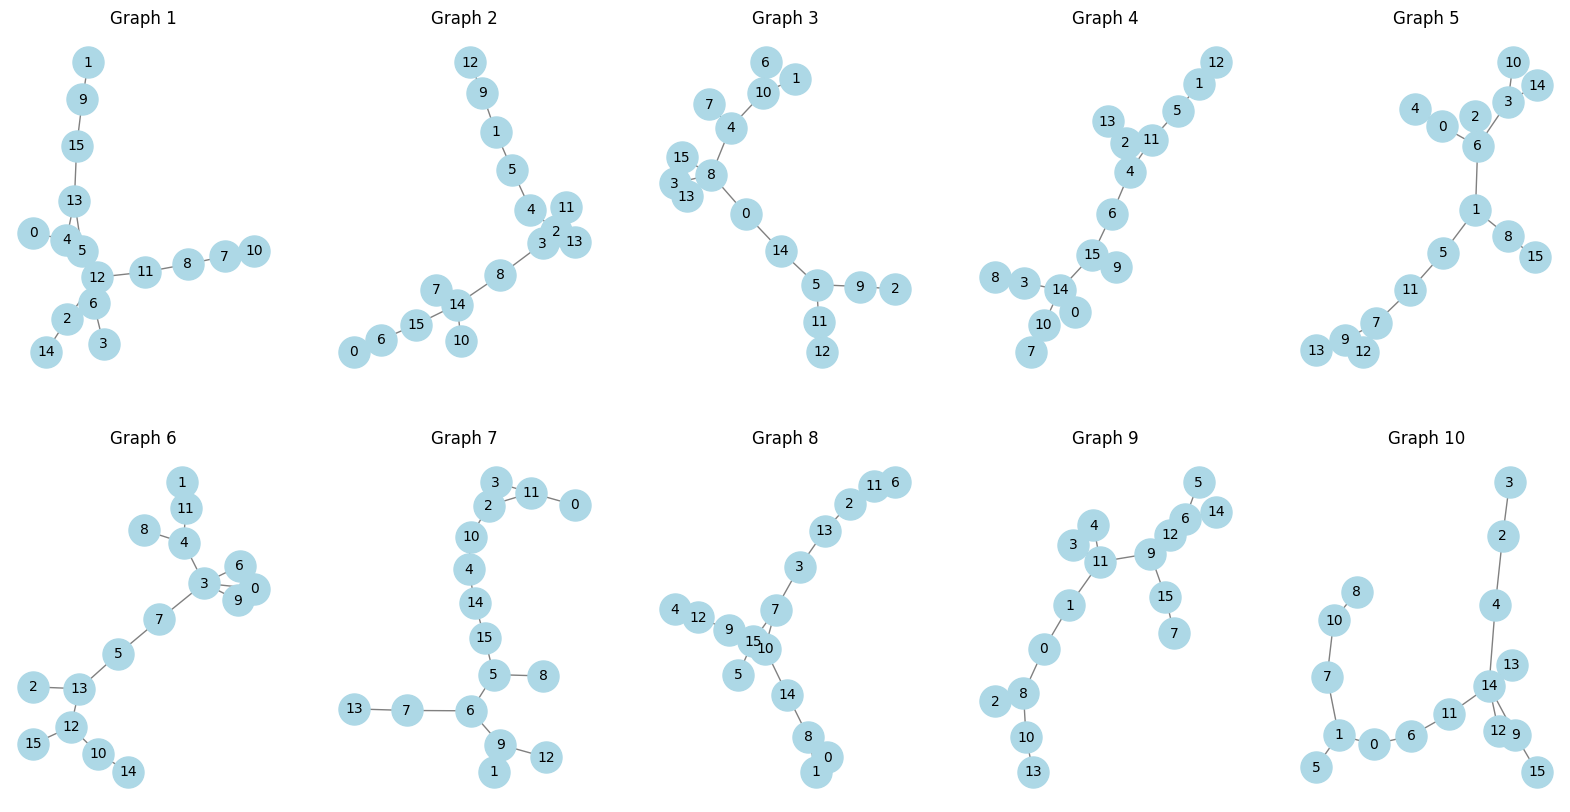

Node 0 is part of 19.00% of the total cycles.
Node 1 is part of 17.50% of the total cycles.
Node 2 is part of 19.70% of the total cycles.
Node 3 is part of 16.90% of the total cycles.
Node 4 is part of 18.10% of the total cycles.
Node 5 is part of 19.10% of the total cycles.
Node 6 is part of 18.00% of the total cycles.
Node 7 is part of 18.50% of the total cycles.
Node 8 is part of 19.50% of the total cycles.
Node 9 is part of 19.30% of the total cycles.
Node 10 is part of 19.70% of the total cycles.
Node 11 is part of 18.80% of the total cycles.
Node 12 is part of 19.90% of the total cycles.
Node 13 is part of 17.80% of the total cycles.
Node 14 is part of 18.20% of the total cycles.
Node 15 is part of 20.00% of the total cycles.


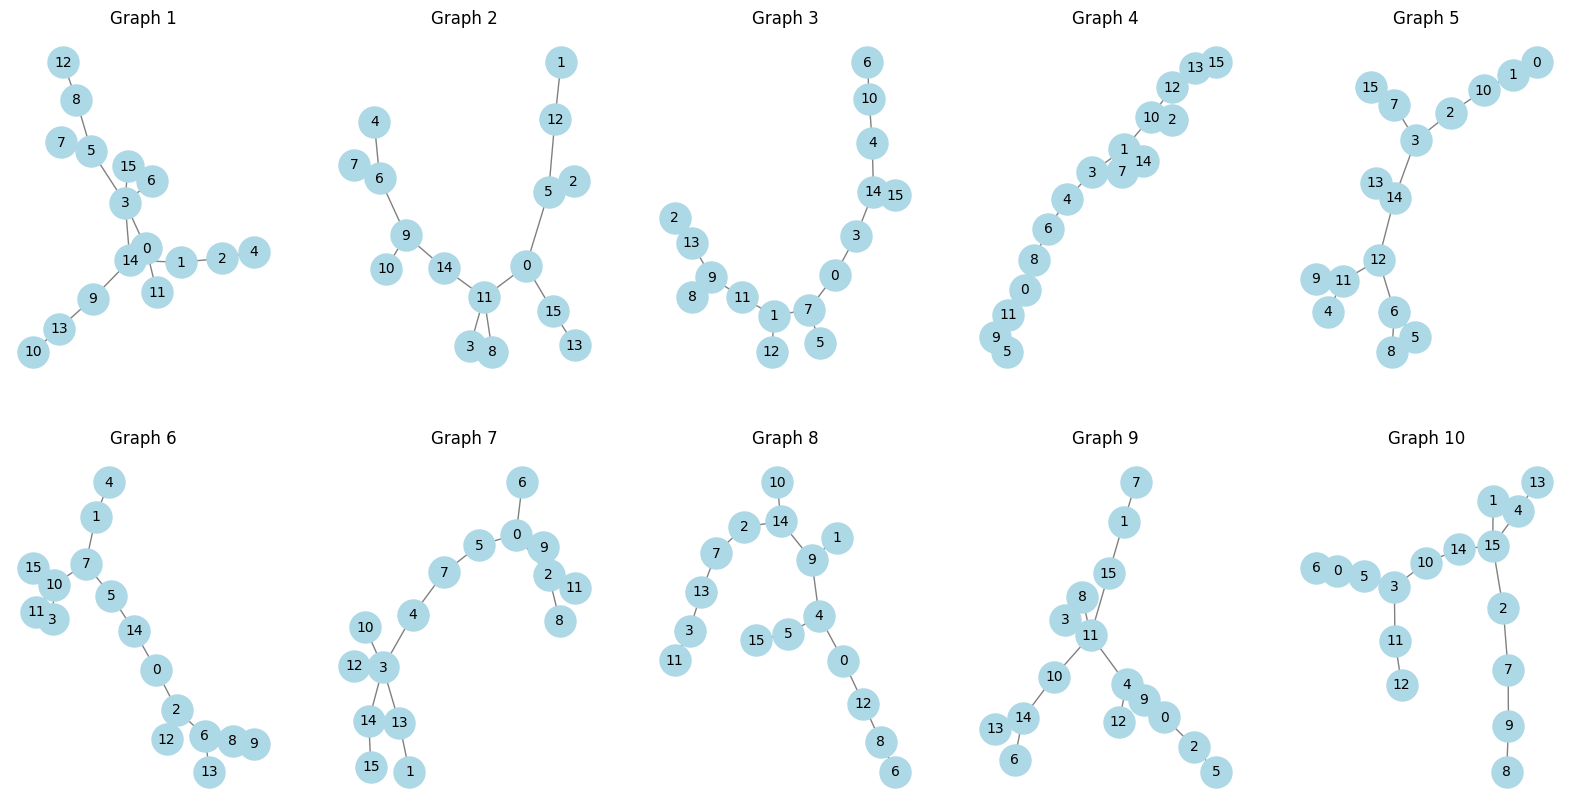

In [860]:
def generate_non_isomorphic_graphs(num_nodes, allow_cycles):
    def generate_random_tree(n):
        tree = nx.random_tree(n)
        return tree
    
    def generate_random_graph_with_one_triangle(n, node_participation):
        # Create a tree
        graph = generate_random_tree(n)
           # List all nodes with degree 2 or more
        nodes_with_degree_2 = [node for node in graph.nodes() if graph.degree(node) >= 2]
        # Select a random node with degree 2 or more
        node = random.choice(nodes_with_degree_2)

        neighbors = list(graph.neighbors(node))
        # Selected randomly 2 numbers from the neighbors of the node
        a, b = random.sample(neighbors, 2)
        graph.add_edge(a, b)

        triangle_nodes = [node, a, b]
        
        nodes = list(graph.nodes)
        
        # Add one triangle (3-node cycle) to the directed graph
        if n >= 3:
            for node in triangle_nodes:
                node_participation[node] += 1
        
        return graph
    
    graphs = []
    node_participation = defaultdict(int)
    if allow_cycles:
        for _ in range(1000):  # Generate 1000 different graphs to ensure non-isomorphism
            graphs.append(generate_random_graph_with_one_triangle(num_nodes, node_participation))
    else:
        for _ in range(1000):
            graphs.append(generate_random_tree(num_nodes))
    
    non_isomorphic_graphs = []
    for g in graphs:
        if all(not nx.is_isomorphic(g, existing_g) for existing_g in non_isomorphic_graphs):
            non_isomorphic_graphs.append(g)
        # non_isomorphic_graphs.append(g)
    print(len(non_isomorphic_graphs))
    # Print the number of edges in each graph and which type of graph it is
    for g in non_isomorphic_graphs:
        print(f"Number of edges: {g.number_of_edges()}, Is tree: {nx.is_tree(g)}")
    return non_isomorphic_graphs, node_participation

def plot_graphs(graphs, node_participation, num_nodes, allow_cycles):
    plt.figure(figsize=(20, 10))
    for i, g in enumerate(graphs[:10]):
        plt.subplot(2, 5, i + 1)
        nx.draw(g, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
        plt.title(f'Graph {i + 1}')
    plt.show()
    
    if allow_cycles:
        total_cycles = sum(node_participation.values()) // 3  # Each cycle involves 3 nodes
        for node in range(num_nodes):
            percentage = (node_participation[node] / total_cycles) * 100
            print(f'Node {node} is part of {percentage:.2f}% of the total cycles.')

# Example usage
num_nodes = 16
allow_cycles = True
graphs_with_cycles, node_participation_with_cycles = generate_non_isomorphic_graphs(num_nodes, allow_cycles)
allow_cycles = False
graphs_without_cycles, node_participation_without_cycles = generate_non_isomorphic_graphs(num_nodes, allow_cycles)

plot_graphs(graphs_with_cycles[-10:], node_participation_with_cycles, num_nodes, True)  # Plot the first 10 non-isomorphic graphs with cycles
plot_graphs(graphs_without_cycles[-10:], node_participation_without_cycles, num_nodes, False)  # Plot the first 10 non-isomorphic graphs without cycles



### ------------------------------------------------------------------------------------------------------------------

### Dataset with same number of edges 

[(6, 7), (6, 10), (6, 11), (6, 13), (7, 10), (7, 11), (7, 13), (10, 11), (10, 13), (11, 13)]
Adding edge between 6 and 13
[(1, 2), (1, 5), (1, 7), (1, 10), (1, 11), (2, 5), (2, 7), (2, 10), (2, 11), (5, 7), (5, 10), (5, 11), (7, 10), (7, 11)]
Adding edge between 1 and 2
[(0, 2), (0, 3), (0, 5), (0, 8), (0, 9), (2, 5), (2, 8), (2, 9), (3, 5), (3, 8), (3, 9)]
Adding edge between 2 and 5
[(0, 1), (0, 4), (0, 5), (0, 7), (0, 10), (1, 4), (1, 5), (1, 7), (1, 10), (4, 5), (4, 10), (5, 7), (5, 10), (7, 10)]
Adding edge between 4 and 10
[(2, 4), (2, 6), (2, 10), (2, 12), (2, 13), (2, 14), (2, 15), (4, 6), (4, 10), (4, 12), (4, 13), (4, 14), (4, 15), (6, 10), (6, 12), (6, 13), (6, 14), (6, 15), (10, 12), (10, 13), (10, 14), (10, 15), (12, 13), (12, 14), (12, 15), (13, 14), (14, 15)]
Adding edge between 4 and 13
[(0, 4), (0, 9), (0, 10), (0, 14), (0, 15), (4, 9), (4, 10), (4, 14), (4, 15), (9, 10), (9, 14), (9, 15), (10, 14), (10, 15), (14, 15)]
Adding edge between 4 and 14
[(0, 1), (0, 2), (0, 

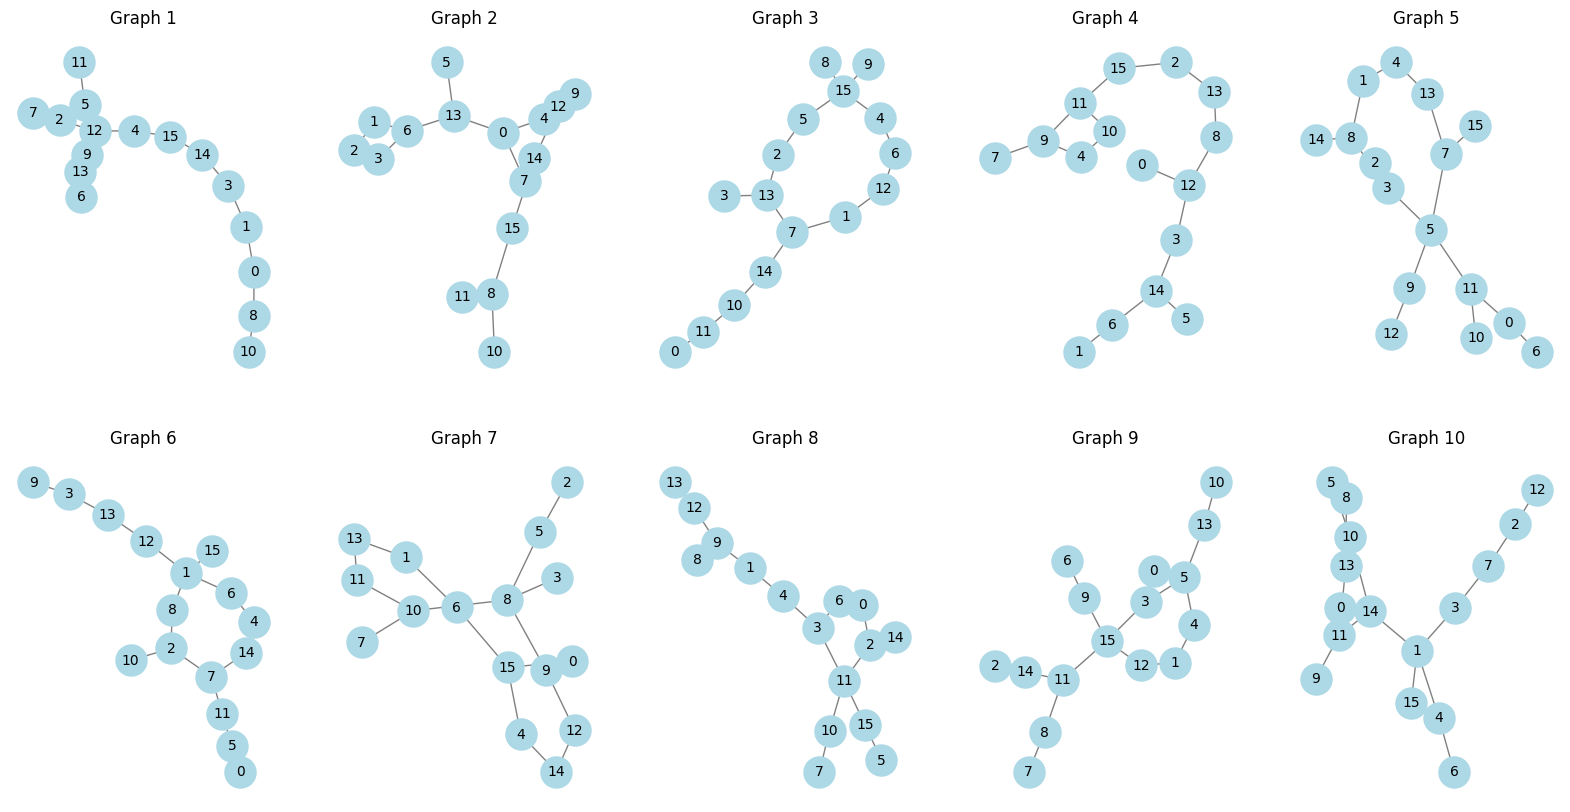

In [861]:
for tree in graphs_without_cycles:
    nodes_with_degree_1 = {node: list(tree.neighbors(node)) for node in tree.nodes() if tree.degree(node) == 1}
    # print(nodes_with_degree_1)
    # pairs of nodes of degree 1 with different neighbors
    pairs = [(node1, node2) for node1, neighbors1 in nodes_with_degree_1.items() for node2, neighbors2 in nodes_with_degree_1.items() if node1 < node2 and neighbors1 != neighbors2]
    print(pairs)
    # Select a random pair of nodes and add that edge to the tree
    if len(pairs) > 0:
        node1, node2 = random.choice(pairs)
        print(f'Adding edge between {node1} and {node2}')
        tree.add_edge(node1, node2)

plot_graphs(graphs_without_cycles[:10], node_participation_without_cycles, num_nodes, False)  # Plot the first 10 non-isomorphic graphs without cycles

In [862]:
# Print the number of edges in each graph and which type of graph it is
for g in graphs_without_cycles:
    print(f"Number of edges: {g.number_of_edges()}, Is tree: {nx.is_tree(g)}")

print("Graphs with cycles")
for g in graphs_with_cycles:
    print(f"Number of edges: {g.number_of_edges()}, Is tree: {nx.is_tree(g)}")

Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree: False
Number of edges: 16, Is tree

### ------------------------------------------------------------------------------------------------------------------

In [863]:
ceros = []
unos = []
for a, l in zip(adj_matrices, labels):
  if l == 1:
    unos.append(a)
  else:
    ceros.append(a)
len(unos), len(ceros)

np.mean([np.sum(c) for c in unos]), np.mean([np.sum(c) for c in ceros])

(32.0, 32.0)

In [864]:
class GraphDataset(Dataset):
    def __init__(self, adj_matrices, labels):
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.labels[idx]

In [865]:
def collate_fn(batch):
    adj_matrices, labels = zip(*batch)

    # Find max number of nodes
    max_nodes = max(len(adj) for adj in adj_matrices)

    # Pad adjacency matrices
    padded_adj = []
    for adj in adj_matrices:
        pad_size = max_nodes - len(adj)
        padded = np.pad(adj, ((0, pad_size), (0, pad_size)), mode='constant')
        padded_adj.append(padded)

    # Convert to PyTorch tensors
    padded_adj = np.array(padded_adj)
    adj_tensor = torch.FloatTensor(padded_adj)

    labels_tensor = torch.FloatTensor(labels)

    return adj_tensor, labels_tensor

In [866]:
# Make adjacency matrix from the graphs with cycles and without cycles
adj_matrices_with_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_with_cycles]
adj_matrices_without_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_without_cycles]
print(len(adj_matrices_with_cycles), len(adj_matrices_without_cycles))
print(adj_matrices_with_cycles[0].shape, adj_matrices_without_cycles[0].shape)

# Combine the adjacency matrices into a single dataset
adj_matrices = np.array(adj_matrices_with_cycles + adj_matrices_without_cycles)
adj_matrices.shape

# Create a list with the values of the labels
labels = [1] * len(adj_matrices_with_cycles) + [0] * len(adj_matrices_without_cycles)
labels = np.array(labels)
labels


989 945
(16, 16) (16, 16)


/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_92894/3761643932.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_with_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_with_cycles]
/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_92894/3761643932.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_without_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_without_cycles]


array([1, 1, 1, ..., 0, 0, 0])

In [867]:
# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
print(train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

1547


In [868]:
# Check if train_loader and test_loader are different, they cant have the same graphs
for i, (train_batch, test_batch) in enumerate(zip(train_loader, test_loader)):
    train_adj, train_labels = train_batch
    test_adj, test_labels = test_batch
    if torch.equal(train_adj, test_adj) and torch.equal(train_labels, test_labels):
        print(f"Error: Train and Test batches {i} are the same!")

Epoch 1/50, Train Loss: 0.6936, Test Loss: 0.6985
Epoch 2/50, Train Loss: 0.6826, Test Loss: 0.7093
Epoch 3/50, Train Loss: 0.6764, Test Loss: 0.6985
Epoch 4/50, Train Loss: 0.6670, Test Loss: 0.7081
Epoch 5/50, Train Loss: 0.6570, Test Loss: 0.7176
Epoch 6/50, Train Loss: 0.6501, Test Loss: 0.7232
Epoch 7/50, Train Loss: 0.6405, Test Loss: 0.6926
Epoch 8/50, Train Loss: 0.6323, Test Loss: 0.7355
Epoch 9/50, Train Loss: 0.6244, Test Loss: 0.7445
Epoch 10/50, Train Loss: 0.6185, Test Loss: 0.7333
Epoch 11/50, Train Loss: 0.6075, Test Loss: 0.7694
Epoch 12/50, Train Loss: 0.6031, Test Loss: 0.7375
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/50, Train Loss: 0.5911, Test Loss: 0.7620
Epoch 14/50, Train Loss: 0.5789, Test Loss: 0.7259
Epoch 15/50, Train Loss: 0.5838, Test Loss: 0.7326
Epoch 16/50, Train Loss: 0.5783, Test Loss: 0.7950
Epoch 17/50, Train Loss: 0.5817, Test Loss: 0.7528
Epoch 18/50, Train Loss: 0.5793, Test Loss: 0.7602
Epoch 00019: reducing learnin

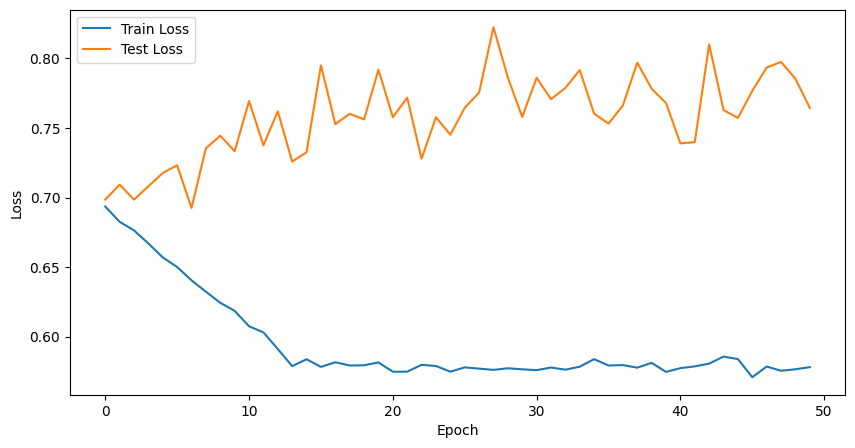

Accuracy: 0.45


In [869]:
# Generate an MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
# Initialize the model
input_size = adj_matrices.shape[1] * adj_matrices.shape[2]
hidden_size = 16
output_size = 1

model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
train_losses = []
test_losses = []
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj = adj.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(adj)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj = adj.view(-1, input_size)
            outputs = model(adj)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.legend()
plt.show()

# Show accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj = adj.view(-1, input_size)
        outputs = model(adj)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

print(f'Accuracy: {correct / total:.2f}')
